In [4]:
%pip install sklearn
%pip transformers
%pip install huggingface
%pip install torch 
%pip install pandas
%pip install sklearn
%pip install datasets
%pip install transformers

You should consider upgrading via the '/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "transformers"
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You 

In [5]:
import pickle

#from sklearn.datasets import fetch_20newsgroups #encountered issues SSLCertificationError with this 
from datasets import load_dataset, load_metric
import os
import pandas as pd
import re
from bs4 import BeautifulSoup
import pickle

from spacy import tokenizer
from spacy.lang.en import English
from sklearn.naive_bayes import GaussianNB, BernoulliNB,MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import svm
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay


/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Methods
acc = load_metric('accuracy'); f1_score = load_metric('f1')

def parse_html(text):
    "removes hyperlink from a piece of text"
    
    soup = BeautifulSoup(text, "html.parser")
    parsed_text = soup.get_text()
    return parsed_text


def spacy_preproc(text):

    "Removes stopwords and punctuation and"
    nlp = English()
    tokenizer = nlp.tokenizer
    refined_text = tokenizer(text)
        
    refined_text = [text for text in refined_text if not text.is_stop]
    refined_text = [text for text in refined_text if not text.is_punct]
    refined_text = [text for text in refined_text if not text.like_email]
    refined_text = [text for text in refined_text if not text.like_url]
    refined_text = [text.text for text in refined_text if not text.like_num]

    text = " ".join(refined_text[:])

    return text

def regex_preproc(text): 

    refined_text = re.sub("(\n)", " ", text) #removes python newline 
    refined_text = re.sub("(\')", "" , refined_text) #removes backslash
    refined_text = re.sub("(<\W+(p >))", " ", refined_text)
    refined_text = re.sub("(\s+)", " ", refined_text) #removes whitespaces
    #refined_text = re.sub("(&amp|>+|-+)", "", refined_text)
    #refined_text = re.sub("\W*(@)", "", refined_text) #removes emails 
    #refined_text = re.sub("(\d+)", "", refined_text) #removes digits

    return refined_text
                
def preproc(text):
  """Preprocesses files"""

  #output = parse_html(text)
  temp_output = spacy_preproc(text)
  final_output = regex_preproc(temp_output)

  return final_output


def prepare_corpus(path):
    """BY date"""
    corpus = {}; temp = []; 
    for topic in os.listdir(path):
        subfolder = path + '/' + topic
        current = []
        for doc in os.listdir(subfolder):
            file = subfolder + '/' + doc
            with open(file, 'r', encoding='utf-8', errors= 'ignore') as t:
               #corpus.append((preproc(" ".join(t.readlines())),topic),)
               temp = " ".join(t.readlines())
            current.append(temp)
        corpus[topic] = current
    return corpus


def extra_long_documents(text, chunk_size = 100):

  """
  Takes in a long documents chunks them into segments of lenght 'chunk_size'
  """
  doc_length = len(text); chunks = []
  
  if doc_length > chunk_size:
    output = range(doc_length//chunk_size)

    chunks = [text[:chunk_size*n] for n in output]
    last_index = output[-1]*chunk_size

    chunks.append(text[last_index:])
  else:
    chunks.append(text)
  
    return chunks 

def extract_features(text, min_df = 0.05 , max_df = 0.5, max_features = 1000, method = "Tfidf"):
    """Count represents the number of features to be chosen from tfidf while text represents text data
    vectorizer is either count_vectorizer or tfidfvectorizer"""
    
    if method.lower() == "tfidf":
        vectorizer = TfidfVectorizer(token_pattern = '[A-Za-z]+', min_df = float(min_df), max_df = float
                                     (max_df), ngram_range = (1,2), max_features = max_features)
    elif method.lower() == "count":
        vectorizer = CountVectorizer(token_pattern = '[A-Za-z]+', min_df = float(min_df), max_df = float
                                     (max_df), ngram_range = (1,2), max_features = max_features)
    else:
        print("Wrong method. Choose between tfidf and Count")

    vec = vectorizer.fit_transform(text)
    X_features = vectorizer.get_feature_names()
    print(vec.shape)
    return vec, X_features

#^\s

def accuracy(prediction, goldstandard):
    acc = 0
    for a,b in zip(prediction,goldstandard):
        if a == b:
            acc+=1
        else:pass
    return (acc/len(prediction))*100

def compute_metrics(predictions,label):

    f_1 = f1_score.compute(predictions = predictions, references = label, pos_label = 1)
    acc_1 = acc.compute(predictions = predictions, references = label)
    return acc_1['accuracy'], f_1['f1']


In [6]:
hyperpartisan_dataset = load_dataset("hyperpartisan_news_detection", "bypublisher") #Not stripped of headers and footers
hyperpartisan_dataset.keys()

Reusing dataset hyperpartisan_news_detection (/Users/max/.cache/huggingface/datasets/hyperpartisan_news_detection/bypublisher/1.0.0/7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012)
100%|██████████| 2/2 [00:00<00:00, 21.17it/s]


dict_keys(['train', 'validation'])

In [7]:
#change to bypublisher because byarticle has no test set.
hyperpartisan_train = hyperpartisan_dataset['train']
hyperpartisan_valid = hyperpartisan_dataset['validation']

hyperpartisan_train = hyperpartisan_train.shuffle(seed = 32)
hyperpartisan_valid = hyperpartisan_valid.shuffle(seed = 32)

Loading cached shuffled indices for dataset at /Users/max/.cache/huggingface/datasets/hyperpartisan_news_detection/bypublisher/1.0.0/7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012/cache-66d6117f38d3c868.arrow
Loading cached shuffled indices for dataset at /Users/max/.cache/huggingface/datasets/hyperpartisan_news_detection/bypublisher/1.0.0/7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012/cache-31fcbf3d65e8fea2.arrow


In [11]:
#If hyperpartisan use 1
#Else use 0
int_labels_train = [1 if x == True else 0 for x in hyperpartisan_train['hyperpartisan']]
int_labels_val = [1 if x == True else 0 for x in hyperpartisan_valid['hyperpartisan']]

In [ ]:
processed_train = [regex_preproc(parse_html(text)) for text in hyperpartisan_train["text"]]
processed_test = [regex_preproc(parse_html(text)) for text in hyperpartisan_train["text"]]

In [ ]:
import sys

parentdir = "/Users/max/Desktop/Dissertation/implementations/Disso-COLD"

sys.path.append(parentdir)

In [8]:
with open('processed_train.pkl', "wb") as out:
  pickle.dump(processed_train, out)

with open('processed_test.pkl', "wb") as out_2:
  pickle.dump(processed_test, out_2)


NameError: name 'processed_train' is not defined

In [ ]:
vec, feat = extract_features(processed_train, method = "tfidf")
vec.shape

(600000, 981)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(600000, 981)

In [ ]:
vec_test, feat_test = extract_features(hyperpartisan_valid['text'])

(600000, 1000)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
vec_test.shape

(600000, 1000)

RELOADING EXTRACTED FEATURES - Obtained using full dataset

In [1]:
import pickle

features = "features_mat_1000.pkl"
test_features = "features_mat_1000_test.pkl"

with open (features, 'rb') as ins:
  vec = pickle.load(ins)

with open(test_features, "rb") as test_in:
  vec_test = pickle.load(test_in)

/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_1495/3073215637.py:7: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  vec = pickle.load(ins)
/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_1495/3073215637.py:10: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  vec_test = pickle.load(test_in)


In [33]:
vec.shape

(600000, 981)

In [2]:
#Initialising multinomial naive bayes

mnb = {}; svm= {} ; bnb = {}
num_of_features = [item for item in range(100, vec.shape[1], 100)]

In [9]:
MNB = MultinomialNB()
BNB = BernoulliNB()
GNB = GaussianNB()
svc_classifier = svm.SVC(decision_function_shape='ovo')

In [10]:
def eval_hyper(model, x, y):
  model.fit(x[:,:900],y)
  preds = model.predict(vec_test[:,:900])
  f1 = f1_score.compute(predictions= preds, references = int_labels_val)

  print(f1)
  ConfusionMatrixDisplay.from_estimator(model, vec_test[:,:900], y)
  

{'f1': 0.5889209919023435}


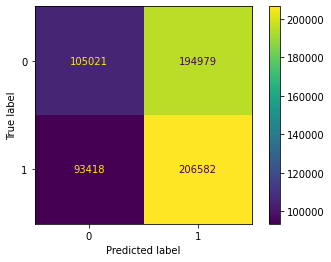

In [35]:
eval_hyper(MNB, vec, int_labels_val)

{'f1': 0.5595236608759403}


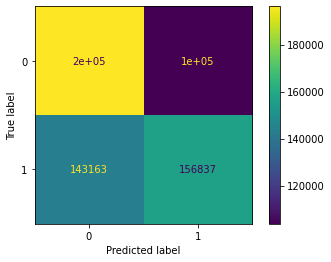

In [36]:
eval_hyper(BNB, vec, int_labels_val)

In [12]:
eval_hyper(svc_classifier,vec, int_labels_val)

ASSESSING EFFECT OF NUMBER OF FEATURES ON PERFORMANCE

In [ ]:
for sub_set in num_of_features:

  #Fitting features and output labels
  MNB.fit(vec[:,:sub_set],int_labels_train)
  BNB.fit(vec[:,:sub_set],int_labels_train)
  svc_classifier.fit(vec[:, :sub_set], int_labels_train)

  #assign test vector and predict 
  test_vec = vec_test[:,:sub_set]
  pred_mnb = MNB.predict(test_vec)
  pred_bnb = BNB.predict(test_vec)
  svc_pred = svc_classifier.predict(test_vec)

  #Score 
  mnb_f1 = f1_score.compute(preds = pred_mnb, references = int_labels_val)
  mnb['f1'] = mnb.get('f1', [])
  mnb['f1'].append(mnb_f1)

  bnb_f1 = f1_score.compute(preds = pred_bnb, references = int_labels_val)
  bnb['f1'] = bnb.get('f1', [])
  bnb['f1'].append(bnb_f1)

  svc_f1 = f1_score.compute(preds = pred_mnb, references = int_labels_val)
  svm['f1'] = svm.get('f1', [])
  svm['f1'].append(svc_f1)

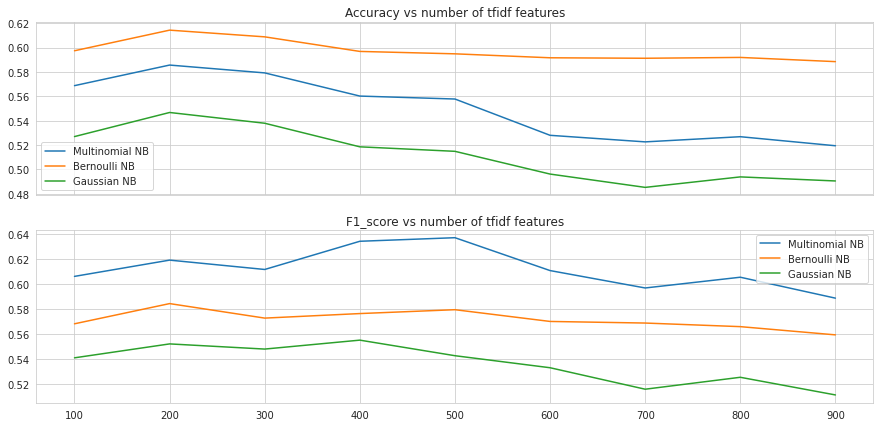

In [ ]:
from IPython.core.pylabtools import figsize
import seaborn as sns
import matplotlib.pyplot as plt 

sns.set_style("whitegrid")
sns.set_color_codes(palette = "deep")

#fig,ax = plt.subplots(2,1, sharex = True, figsize = (15,7))

#ax[0].plot(num_of_features,mnb['acc'])
#ax[0].plot(num_of_features,bnb['acc'])
#ax[0].title.set_text("Accuracy vs number of tfidf features")
#ax[0].legend(['Multinomial NB', 'Bernoulli NB', 'Gaussian NB'], )

plt.title("Naive Bayes and SVM: F1-score vs number of features ")

plt.plot(num_of_features,mnb['f1'])
plt.plot(num_of_features,bnb['f1'])
plt.plot(num_of_features,svm['f1'])
#plt.title.set_text("Naive_Bayes :F1_score vs number of tfidf features")
plt.legend('Multinomial NB', 'Bernoulli NB', 'SVM with ovo function')


In [ ]:
vec.shape

(600000, 981)

20NEWSGROUP

In [53]:
import sys 
sys.path.append("/Users/max/Desktop/Dissertation/implementations/Disso-COLD/functions")

from utils import PrepareCorpus, AssessData

In [45]:
parentdir = "/Users/max/Desktop/Dissertation/implementations/Disso-COLD/Datasets"

train = parentdir+"/20news-bydate"+"/20news-bydate-train"
test =  parentdir+"/20news-bydate"+ "/20news-bydate-train"

In [47]:
news_group_train = PrepareCorpus(train)
news_group_test = PrepareCorpus(test)

In [48]:
news_group_train._prep()
news_group_test._prep()

news_group_train = news_group_train._corpus
news_group_test = news_group_test._corpus

In [ ]:
news_group_train['talk.politics.mideast'][0]

In [ ]:
id2label = {x:i for i,x in enumerate(news_group_train.keys())}
id2label

In [ ]:
#Converting input into a dictionary 

news_group_train_modif = {}
news_group_test_modif = {}

news_group_train_modif['text'] = []; news_group_train_modif['labels'] = []
news_group_test_modif['text'] = []; news_group_test_modif['labels'] = []

for key,value in news_group_train.items():
    list_of_strings = value
    lab = id2label[key]
    for text in list_of_strings:
        news_group_train_modif['text'].append(text)
        news_group_train_modif['labels'].append(lab)


for key,value in news_group_test.items():
    list_of_strings = value
    lab = id2label[key]
    for text in list_of_strings:
        news_group_test_modif['text'].append(text)
        news_group_test_modif['labels'].append(lab)


Exporting 20news distribbution

import json

train_file = "data_dict/20news_train.json"
test_file = "data_dict/20news_test.json"
id_2_label = "data_dict/id2label.json"

with open(train_file, "w") as ins_1:
    json.dump(news_group_train_modif, ins_1)

with open(test_file, "w") as ins_2:
    json.dump(news_group_test_modif, ins_2)

with open(id_2_label, "w") as ins_3:
    json.dump(id2label, ins_3)

CLEANING FILES 

In [ ]:
clean = [preproc(x) for x in news_group_train_modif['text']]
news_group_train_modif['text'] = clean

clean = [preproc(x) for x in news_group_test_modif['text']]
news_group_test_modif['text'] = clean

In [ ]:
train_news_vec, news_feat = extract_features(news_group_train_modif['text'], method = "Tfidf")
test_news_vec, news_feat = extract_features(news_group_test_modif['text'], method = "Tfidf")

In [ ]:
MNB = MultinomialNB()
BNB = BernoulliNB()
GNB = GaussianNB()
svc_classifier = svm.SVC(decision_function_shape='ovo')

In [ ]:
MNB.fit(train_news_vec, news_group_train_modif['labels'])
BNB.fit(train_news_vec, news_group_train_modif['labels'])
svc_classifier.fit(train_news_vec, news_group_train_modif['labels'])

In [ ]:
mnb_news_pred = MNB.predict(test_news_vec)
bnb_news_pred = BNB.predict(test_news_vec)
svm_pred = svc_classifier.predict(test_news_vec)
compute_metrics(mnb_news_pred, news_group_test_modif['labels']), compute_metrics(bnb_news_pred, news_group_test_modif['labels'])

(50.866183489482054, 43.07053208414354, 39.28760827293619)

In [ ]:
f1_score.compute(predictions = svm_pred, references = news_group_test_modif['labels'], average = "weighted")

{'f1': 0.8875869105270722}

Converting 20Newsgroup to Classes

In [50]:
id2classes = {'talk.politics.mideast': 0, 'rec.autos': 4, 'comp.sys.mac.hardware': 2, 'alt.atheism': 5, 'rec.sport.baseball': 1, 'comp.os.ms-windows.misc': 2, 'rec.sport.hockey': 1, 'sci.crypt': 3, 'sci.med': 3, 'talk.politics.misc': 0, 'rec.motorcycles': 4, 'comp.windows.x': 2, 'comp.graphics': 2, 'comp.sys.ibm.pc.hardware': 2, 'sci.electronics': 3, 'talk.politics.guns': 0, 'sci.space': 3, 'soc.religion.christian': 5, 'misc.forsale': 6, 'talk.religion.misc': 5}

In [51]:
#Converting input into a dictionary 

news_group_train_modif = {}
news_group_test_modif = {}

news_group_train_modif['text'] = []; news_group_train_modif['labels'] = []
news_group_test_modif['text'] = []; news_group_test_modif['labels'] = []

for key,value in news_group_train.items():
    list_of_strings = value
    lab = id2classes[key]
    for text in list_of_strings:
        news_group_train_modif['text'].append(text)
        news_group_train_modif['labels'].append(lab)


for key,value in news_group_test.items():
    list_of_strings = value
    lab = id2classes[key]
    for text in list_of_strings:
        news_group_test_modif['text'].append(text)
        news_group_test_modif['labels'].append(lab)

In [ ]:
news_group_test_modif['labels']

(array([1575., 1197.,    0., 2936.,    0., 2373., 1192.,    0., 1456.,
         585.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

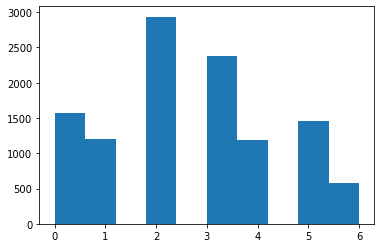

In [65]:
plt.hist(news_group_train_modif['labels'])

(array([1575., 1197.,    0., 2936.,    0., 2373., 1192.,    0., 1456.,
         585.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

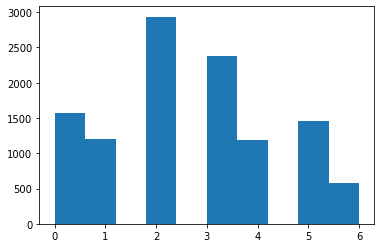

In [63]:
import matplotlib.pyplot as plt
plt.hist(news_group_test_modif['labels'])

In [52]:
clean = [preproc(x) for x in news_group_train_modif['text']]
news_group_train_modif['text'] = clean

clean = [preproc(x) for x in news_group_test_modif['text']]
news_group_test_modif['text'] = clean

KeyboardInterrupt: 

In [ ]:
train_news_vec, news_feat = extract_features(news_group_train_modif['text'], method = "Tfidf")
test_news_vec, news_feat = extract_features(news_group_test_modif['text'], method = "Tfidf")

In [ ]:
MNB = MultinomialNB()
BNB = BernoulliNB()
GNB = GaussianNB()
svc_classifier = svm.SVC(decision_function_shape='ovo')

In [ ]:
MNB.fit(train_news_vec, news_group_train_modif['labels'])
BNB.fit(train_news_vec, news_group_train_modif['labels'])
svc_classifier.fit(train_news_vec, news_group_train_modif['labels'])

In [ ]:
mnb_news_pred = MNB.predict(test_news_vec)
bnb_news_pred = BNB.predict(test_news_vec)
svm_pred = svc_classifier.predict(test_news_vec)
compute_metrics(mnb_news_pred, news_group_test_modif['labels']), compute_metrics(bnb_news_pred, news_group_test_modif['labels'])

(50.866183489482054, 43.07053208414354, 39.28760827293619)

IMDB

In [4]:
imdb = load_dataset('imdb')
imdb

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
#0 corresponds to negative review while 1 corresponds to positive reviews
label2text = {0:'negative', 1: 'positive'}

train_imdb = imdb['train']
test_imdb = imdb['test']
set(train_imdb['label'])

imdb_train_text = {i:x for i,x in enumerate(train_imdb['text'])}
imdb_test_text = {i:x for i,x in enumerate(test_imdb['text'])}

temp = []
imdb_labels_text_train = {i:temp.append(x) for i,x in zip(train_imdb['label'], train_imdb['text'])}

temp = []
imdb_labels_text_test = {i:temp.append(x) for i,x in zip(test_imdb['label'], test_imdb['text'])}

imdb_train_labels = {i:x for i,x in enumerate(train_imdb['label'])}
imdb_test_labels = {i:x for i,x in enumerate(test_imdb['label'])}

In [6]:
train_vec, _ = extract_features(imdb_train_text.values())
test_vec, _ = extract_features(imdb_test_text.values())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(25000, 630)
(25000, 621)


In [7]:
MNB = MultinomialNB()
BNB = BernoulliNB()
GNB = GaussianNB()

In [8]:
MNB.fit(train_vec[:, :600], train_imdb['label'])
GNB.fit(train_vec[:, :600].toarray(), train_imdb['label'])
BNB.fit(train_vec[:, :600], train_imdb['label'])

BernoulliNB()

In [10]:
def eval_imdb(model,x,y):
  preds = model.predict(x[:, :600])

  f1 = f1_score.compute(predictions = preds, references = y)
  ConfusionMatrixDisplay.from_estimator(model, x[:,:600], y)
  print(f1)

{'f1': 0.4513527453462747}


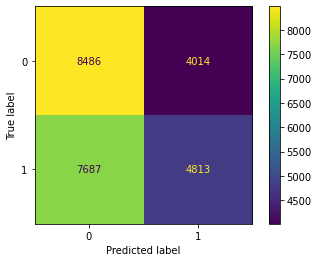

In [11]:
eval_imdb(MNB,test_vec[:, :600], test_imdb['label'])

{'f1': 0.5520565552699229}


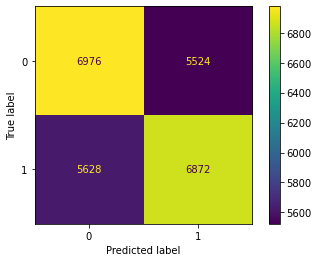

In [12]:
eval_imdb(BNB, test_vec[:, :600].toarray(), test_imdb['label'])

In [13]:
svc_classifier = svm.SVC(decision_function_shape='ovo')
svc_classifier.fit(train_vec[:,:600],train_imdb['label'])

SVC(decision_function_shape='ovo')

{'f1': 0.4964569838716689}


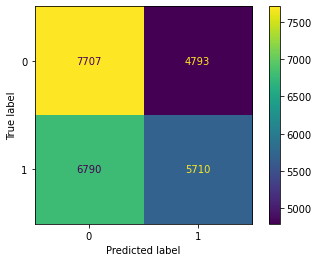

In [14]:
eval_imdb(svc_classifier, test_vec[:, :600].toarray(), test_imdb['label'])

In [ ]:
#Run on Google Colab, Access 20/News from Drive